In [20]:
import pandas as pd
import datetime
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import numpy as np
from cvxopt import matrix, solvers, blas

def get_first_values(data):
    print (data.iloc(0))

start = datetime.datetime(2006, 1, 1)
end = datetime.datetime(2016, 8, 1)
shift = 1 #daily

symbols = [
    #'IJH', #iShares Core S&P 500 Mid-Cap
    #'IVW', #iShares S&P 500 Growth
    #'IJR', #iShares Core S&P 500 Small-Cap
    #'AAPL',
    #'GLD',
    #'SPY',
    'VTI',
    #'VTV',
    #'VOE',
    #'VBR',
    'VEA', # Foreign stocks
    'VWO', # Emerging markets
    'VIG', # Dividend stocks
    'VNQ', # Real Estate
    #'VTIP',
    #'SHV',
    #'MUB',
    'LQD', # Corporate Bonds
    'EMB', # EM Bonds
    #'VWOB'
 ]

data = {}
for symbol in symbols:
    data[symbol] = web.DataReader(symbol, 'yahoo', start, end)

price = pd.DataFrame({sym: dataframe['Adj Close'] for sym,dataframe in data.items()})

print (price)

                   EMB         LQD        VEA        VIG        VNQ  \
Date                                                                  
2008-01-02   66.373501   73.546272  36.972539  45.649377  42.369477   
2008-01-03   66.491220   73.303614  37.034404  45.674256  41.048672   
2008-01-04   66.523921   73.906790  36.222416  44.886483  39.382107   
2008-01-07   66.674336   73.816662  36.268816  45.193299  39.748612   
2008-01-08   66.837834   73.677997  35.974953  44.546497  38.372488   
2008-01-09   66.785518   73.525473  36.206949  44.927944  39.050178   
2008-01-10   66.844375   73.310544  36.168284  45.325976  39.651800   
2008-01-11   66.602397   73.844395  35.541891  44.695759  39.658714   
2008-01-14   66.831298   73.539337  36.114151  44.969405  39.492750   
2008-01-15   66.942475   73.934523  34.977367  44.165046  38.690587   
2008-01-16   67.034033   73.823596  34.258177  43.990908  39.133159   
2008-01-17   66.975176   74.170251  33.678185  42.954364  38.600688   
2008-0

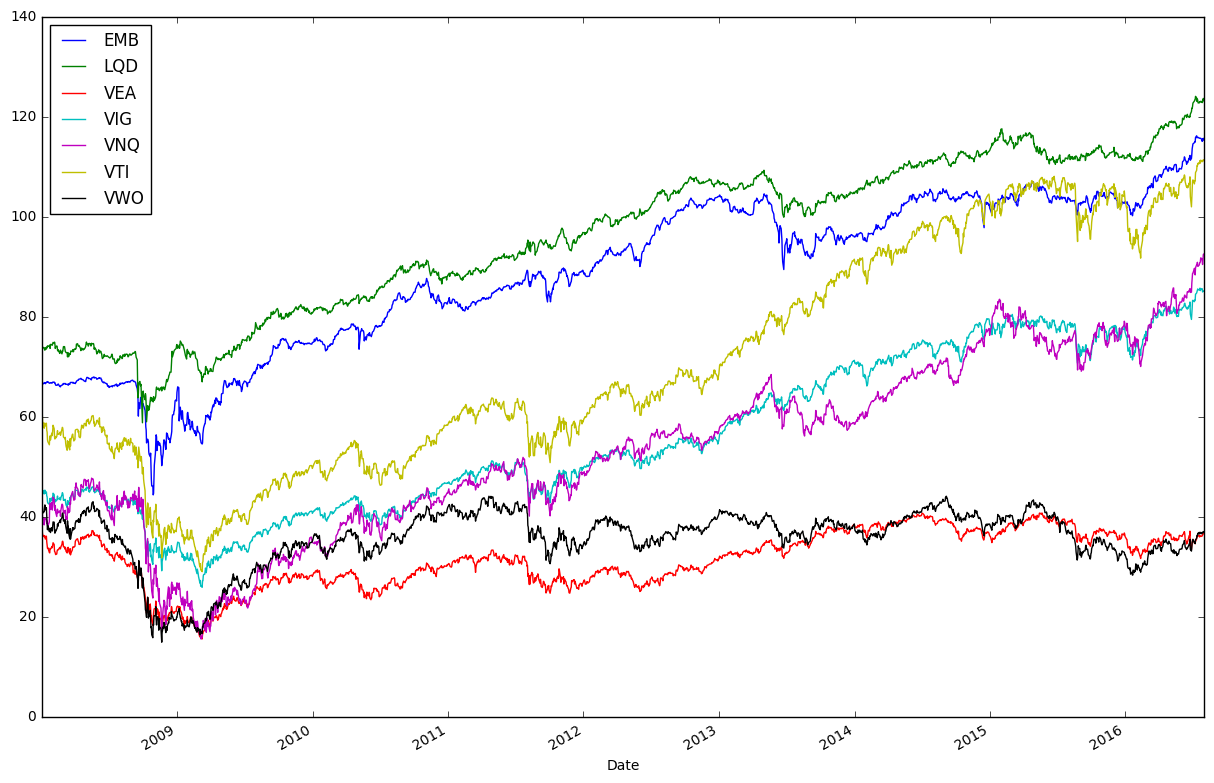

In [21]:
price.plot(figsize=(15,10))
plt.show()

In [22]:
#252 trading days a year
#avg_yearly_returns = (price/price.shift(252)-1).mean()

daily_returns = (price/price.shift(shift)) - 1
daily_returns_mean = daily_returns.mean()
daily_returns_variance = daily_returns.var()
daily_returns_covariance = daily_returns.cov()

#print ("Average Returns:\n%s\n" % (avg_yearly_returns*100))
print ("Daily Returns Mean:\n%s\n" % daily_returns_mean)
print ("Daily Returns Variance:\n%s" % daily_returns_variance)
print ("Daily Returns Covariance:\n%s" % daily_returns_covariance)

Daily Returns Mean:
EMB    0.000282
LQD    0.000255
VEA    0.000127
VIG    0.000358
VNQ    0.000639
VTI    0.000377
VWO    0.000150
dtype: float64

Daily Returns Variance:
EMB    0.000053
LQD    0.000033
VEA    0.000262
VIG    0.000139
VNQ    0.000554
VTI    0.000188
VWO    0.000416
dtype: float64

Daily Returns Covariance:
          EMB       LQD       VEA       VIG       VNQ       VTI       VWO
EMB  0.000053  0.000010  0.000032  0.000020  0.000029  0.000025  0.000042
LQD  0.000010  0.000033  0.000015  0.000006  0.000011  0.000009  0.000019
VEA  0.000032  0.000015  0.000262  0.000169  0.000263  0.000201  0.000293
VIG  0.000020  0.000006  0.000169  0.000139  0.000216  0.000158  0.000206
VNQ  0.000029  0.000011  0.000263  0.000216  0.000554  0.000256  0.000335
VTI  0.000025  0.000009  0.000201  0.000158  0.000256  0.000188  0.000246
VWO  0.000042  0.000019  0.000293  0.000206  0.000335  0.000246  0.000416


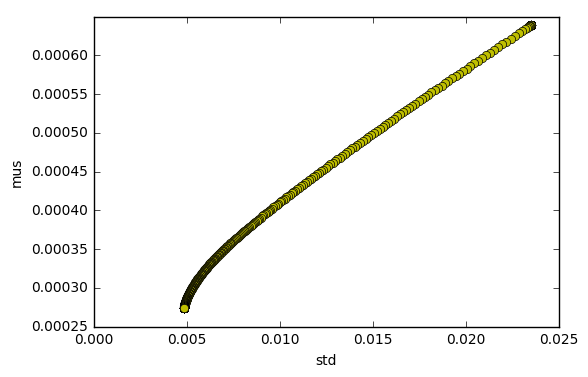

In [56]:
n = len(symbols)

N = 1000
mus = [10**(5.0 * t/N - 1.0) for t in range(N)]
    
S = matrix(daily_returns_covariance.values)
pbar = matrix(daily_returns_mean.values)
    
# Create constraint matrices
G = -matrix(np.eye(n))   # negative n x n identity matrix
h = matrix(0.0, (n ,1))
A = matrix(1.0, (1, n))
b = matrix(1.0)
    
# Calculate efficient frontier weights using quadratic programming
solvers.options['show_progress'] = False
portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
              for mu in mus]

## CALCULATE RISKS AND RETURNS FOR FRONTIER
returns = [blas.dot(pbar, x) for x in portfolios]
risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]

plt.ylabel('mus')
plt.xlabel('std')
plt.plot(risks, returns, 'y-o')
plt.show()

[  5.87416500e+04  -2.12427939e+00   9.73707130e-04]
0.011912965522
0.000128748181768
7.34220528285e+58


/home/abhinav/fin/fin/lib/python3.5/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


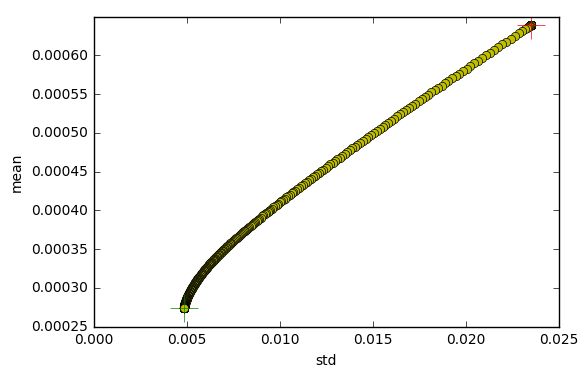

VTI	0.000919
VEA	0.000627
VWO	0.000089
VIG	0.002662
VNQ	99.992071
LQD	0.003500
EMB	0.000133


In [58]:
## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
m1 = np.polyfit(returns, risks, 2)
print (m1)
v = 0.00045
print (m1[0]*(v**2)+m1[1]*v+m1[2])
x1 = np.sqrt(m1[2] / m1[0])
print (x1)

## CALCULATE THE OPTIMAL PORTFOLIO
qp = solvers.qp(matrix(x1 * S), -pbar, G, h, A, b)['x']

m2 = np.polyfit(risks, mus, 30)
riskp = 0.55
v = np.min(risks)+(np.max(risks)-np.min(risks))*riskp
r = m2[0]*(v**2)+m2[1]*v+m2[2]
print (r)

## CALCULATE THE OPTIMAL PORTFOLIO
mp = solvers.qp(matrix(r * S), -pbar, G, h, A, b)['x']

plt.ylabel('mean')
plt.xlabel('std')
plt.plot(risks, returns, 'y-o')
plt.plot(np.sqrt(blas.dot(qp, S*qp)), blas.dot(pbar, qp), 'r+', markersize=20)
plt.plot(np.sqrt(blas.dot(mp, S*mp)), blas.dot(pbar, mp), 'g+', markersize=20)
plt.show()

for i in range(len(symbols)):
    print ("%s\t%f" % (symbols[i], (wt[i]*100)))

In [37]:
y = (price/price.shift(252))-1
ym = np.matrix(y.mean().values)
print (ym*np.array(wt))

[[ 0.13954718]]
